### Notebook part 2

# Seq2Seq LSTM Modeling
_By **Avi Patel**_

## Overview
This project seeks to create a model that creates one line abstractive summary of a given news article. This model will help to get a quick idea on what the article is all about without having to read all whole news.


## Business Problem
News/Media/Blogging Companies always wants a catchy  headlines for the articles they post so that they can get maximum number of clicks. A machine learning algorithm can be  used to create a headline based on the context of the article.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

import os
import json

import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/cleaned_news_summary.csv')

In [ ]:
df.replace('_START_','', regex=True, inplace=True)
df.replace('_END_','', regex=True, inplace=True)

df.head()

,text,summary,cleaned_text,cleaned_summary
0,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",upGrad learner switches to career in ML & Al w...,saurav kant an alumnus of upgrad and iiit-b pg...,upgrad learner switches to career in ml al wit...
1,Kunal Shah's credit card bill payment platform...,Delhi techie wins free food from Swiggy for on...,kunal shah credit card bill payment platform c...,delhi techie wins free food from swiggy for on...
2,New Zealand defeated India by 8 wickets in the...,New Zealand end Rohit Sharma-led India's 12-ma...,new zealand defeated india by wickets in the f...,new zealand end rohit sharma-led india 12-matc...
3,"With Aegon Life iTerm Insurance plan, customer...",Aegon life iTerm insurance plan helps customer...,with aegon life iterm insurance plan customers...,aegon life iterm insurance plan helps customer...
4,Speaking about the sexual harassment allegatio...,"Have known Hirani for yrs, what if MeToo claim...",speaking about the sexual harassment allegatio...,have known hirani for yrs what if metoo claims...


**Drop NaN Rows**

---



In [ ]:
df.dropna(axis=0, inplace=True)

In [ ]:
df.shape

(102797, 4)

**Count total words in Summary and Text**

---



In [ ]:
text_count = []
summary_count = []

In [ ]:
for txt in df['cleaned_text']:
    text_count.append(len(txt.split()))
for smry in df['cleaned_summary']:
    summary_count.append(len(smry.split()))

In [ ]:
df['text_count'] = text_count
df['summary_count'] = summary_count

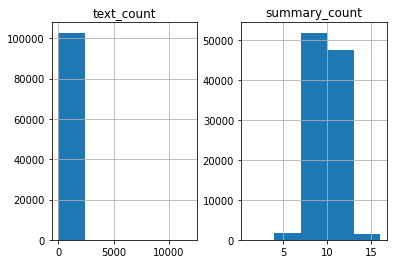

In [ ]:
df.hist(bins = 5)
plt.show()

In [ ]:
df.describe()

,text_count,summary_count
count,102797.000000,102797.000000
mean,71.254531,9.440976
std,98.950307,1.413048
min,1.000000,1.000000
25%,56.000000,9.000000
50%,58.000000,9.000000
75%,59.000000,10.000000
max,11987.000000,16.000000


**Filter Outliers**

---



In [ ]:
summary_records = 0
for i in df.cleaned_summary:
    if( (len(i.split()) >= 7) & (len(i.split()) <= 25) ):
        summary_records += 1
print('Summary data bewteen 7 to 16 words (%) = ',summary_records/df.shape[0] * 100)

Summary data bewteen 7 to 16 words (%) =  98.31901709193848


In [ ]:
text_records = 0
for i in df.cleaned_text:
    if( (len(i.split()) >= 5) & (len(i.split()) <= 150) ):
        text_records += 1
print('Text data bewteen 25 to 600 words (%) = ',text_records/df.shape[0] * 100)

Text data bewteen 25 to 600 words (%) =  96.01836629473623


In [ ]:
df_filtered = df[(df.summary_count <= 25) & (df.summary_count >= 7)]

In [ ]:
df_filtered = df_filtered[ (df_filtered.text_count >= 5)  & (df_filtered.text_count <= 100) ]

In [ ]:
df_filtered.shape

(96843, 6)

In [ ]:
df = df_filtered.copy()

**Adding Start and End Token to the summary**

---



In [ ]:
df.cleaned_summary = df.cleaned_summary.apply(lambda x : 'sostok '+ x + ' eostok')

In [ ]:
df = df[['cleaned_text','cleaned_summary']]

In [ ]:
df.head(2)

,cleaned_text,cleaned_summary
0,saurav kant an alumnus of upgrad and iiit-b pg...,sostok upgrad learner switches to career in ml...
1,kunal shah credit card bill payment platform c...,sostok delhi techie wins free food from swiggy...


In [ ]:
max_text_len = 100
max_summary_len = 16

**SEQ2SEQ MODEL BUILDING**

---



In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df.cleaned_text, df.cleaned_summary, test_size=0.1, random_state=0, shuffle=True)

In [ ]:
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_train))

In [ ]:
thresh=1

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 0.0
Total Coverage of rare words: 0.0


In [ ]:
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_train))

#convert text sequences into integer sequences (i.e one-hot encodeing all the words)
x_train_seq = x_tokenizer.texts_to_sequences(x_train) 
x_test_seq = x_tokenizer.texts_to_sequences(x_test)

#padding zero upto maximum length
x_train_padded = pad_sequences(x_train_seq,  maxlen=max_text_len, padding='post')
x_test_padded = pad_sequences(x_test_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc = x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 78464


In [ ]:
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_train))

In [ ]:
thresh=1

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 0.0
Total Coverage of rare words: 0.0


In [ ]:
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_train))

#convert text sequences into integer sequences (i.e one hot encode the text in Y)
y_train_seq = y_tokenizer.texts_to_sequences(y_train) 
y_test_seq = y_tokenizer.texts_to_sequences(y_test) 

#padding zero upto maximum length
y_train_padded = pad_sequences(y_train_seq, maxlen=max_summary_len, padding='post')
y_test_padded = pad_sequences(y_test_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc = y_tokenizer.num_words +1
print("Size of vocabulary in Y = {}".format(y_voc))

Size of vocabulary in Y = 34118


In [ ]:
use_tpu = True #@param {type:"boolean"}

if use_tpu:
    assert 'COLAB_TPU_ADDR' in os.environ, 'Missing TPU; did you request a TPU in Notebook Settings?'

if 'COLAB_TPU_ADDR' in os.environ:
  TF_MASTER = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])
else:
  TF_MASTER=''

tpu_address = TF_MASTER

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(TF_MASTER)
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.experimental.TPUStrategy(resolver)

INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.93.102.10:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.93.102.10:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
from keras import backend as K 
import gensim
from numpy import *
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

K.clear_session()

In [ ]:
with strategy.scope():

  latent_dim = 300
  embedding_dim = 200

  # Encoder
  encoder_inputs = Input(shape=(max_text_len,))

  #embedding layer
  enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

  #encoder lstm 1
  encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
  encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

  #encoder lstm 2
  encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
  encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

  #encoder lstm 3
  encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
  encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)
  

  # Set up the decoder, using `encoder_states` as initial state.
  decoder_inputs = Input(shape=(None,))

  #embedding layer
  dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
  dec_emb = dec_emb_layer(decoder_inputs)

  decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
  decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

  #dense layer
  decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
  decoder_outputs = decoder_dense(decoder_outputs)

  # Define the model 
  model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

  model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 200)     15692800    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 100, 300), ( 601200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics='sparse_categorical_accuracy')

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [ ]:
history=model.fit( [x_train_padded,y_train_padded[:,:-1]], y_train_padded.reshape(y_train_padded.shape[0],y_train_padded.shape[1], 1)[:,1:] ,
                  epochs=100, callbacks=[es], batch_size=128, 
                  validation_data=([x_test_padded,y_test_padded[:,:-1]], y_test_padded.reshape(y_test_padded.shape[0],y_test_padded.shape[1], 1)[:,1:]) )

Epoch 1/100
681/681 [==============================] - 143s 170ms/step - loss: 5.2624 - sparse_categorical_accuracy: 0.3662 - val_loss: 4.8939 - val_sparse_categorical_accuracy: 0.3907
Epoch 2/100
681/681 [==============================] - 89s 130ms/step - loss: 4.8793 - sparse_categorical_accuracy: 0.3886 - val_loss: 4.6083 - val_sparse_categorical_accuracy: 0.4035
Epoch 3/100
681/681 [==============================] - 89s 130ms/step - loss: 4.5835 - sparse_categorical_accuracy: 0.4038 - val_loss: 4.3522 - val_sparse_categorical_accuracy: 0.4179
Epoch 4/100
681/681 [==============================] - 89s 130ms/step - loss: 4.3512 - sparse_categorical_accuracy: 0.4186 - val_loss: 4.1836 - val_sparse_categorical_accuracy: 0.4310
Epoch 5/100
681/681 [==============================] - 89s 130ms/step - loss: 4.1800 - sparse_categorical_accuracy: 0.4309 - val_loss: 4.0596 - val_sparse_categorical_accuracy: 0.4395
Epoch 6/100
681/681 [==============================] - 89s 130ms/step - loss: 4

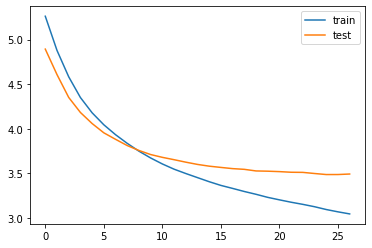

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
import pickle

model.save('news_pre.h5')

with open('y_tokenizer.pickle', 'wb') as handle:
    pickle.dump(y_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
  
with open('x_tokenizer.pickle', 'wb') as handle:
    pickle.dump(x_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


encoder_model.save('encoder.h5')
decoder_model.save('decoder.h5')